# Notebook Controlling PyAE on Asylum Cypher Microscope

### Import

In [1]:
import os
import time
import win32com.client  
import pythoncom
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt

from sys import exit
from scipy import signal
from nifpga import Session
from IPython import display
from joblib import Parallel, delayed
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'nifpga'

#### Start PyAE 

In [ ]:
# Directory of PyAE
exe_path = r'G:\My Drive\AE\PyAE\V3 PyAE 111122 02\V3 PyAE 111122 02.exe'

# Start PyAE
os.startfile(exe_path)
time.sleep(1)  # Wait 1s for PyAE to start

### Connect to PyAE

In [7]:
labview = win32com.client.Dispatch("V3PyAE11112202.Application")

# Get vi reference 'V3_PyAE_01.vi' from PyAE directory
VI = labview.getvireference(r'G:\My Drive\AE\PyAE\V3 PyAE 111122 02\V3 PyAE 111122 02.exe\V3_PyAE_01.vi')  

### Offline Development
-If you are working on offline development, i.e., no Igor, and/or no microscope, and/or no DAQ in your PC, you can set all these to "True". Then, the PyAE will generate artificial BE response when you operate it.


-Or if you are working on a microscope, see all these to "False"

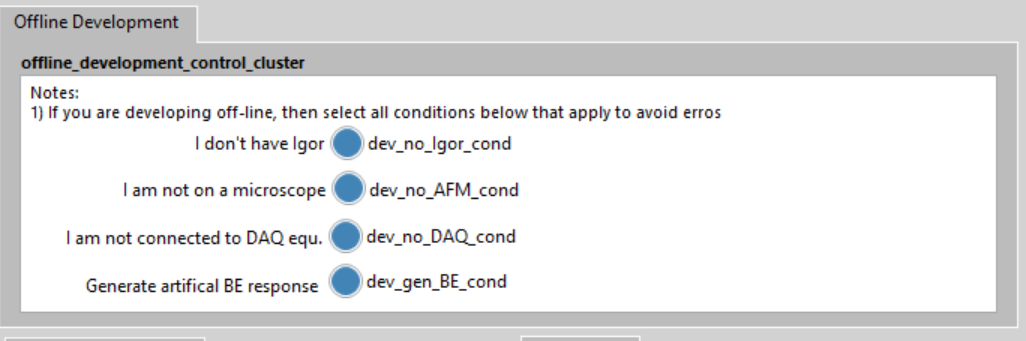

In [8]:
# Set Offline Development
VI.setcontrolvalue('offline_development_control_cluster', (True,True,True,True))  

### Initialize PyAE: 
Get image parameter from IGOR first
-Before we can start to control the microscope through PyAE and Igor, we need to get current image parameter (i.e., current measurement size and coordinates)

-AR_main_variable_array: image size, unit m

-AFM_sensitivity_cluster:

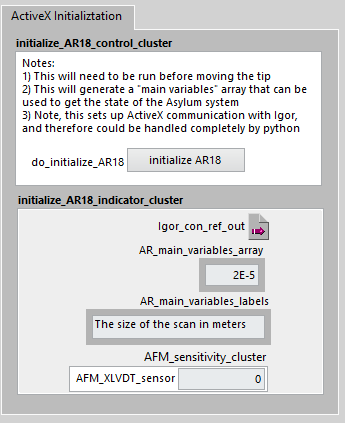

In [9]:
# Initialize
igor_para = VI.getcontrolvalue('main tab')  
VI.setcontrolvalue('initialize_AR18_control_cluster', (True,))  # Initialize
print(igor_para)  

print(VI.getcontrolvalue('initialize_AR18_control_cluster')) # Get control parameter

0
(True,)


### Set IO control parameter

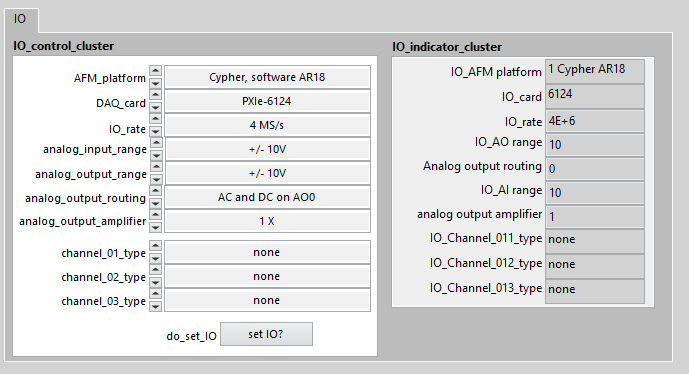

In [ ]:
# Get IO parameters
VI.getcontrolvalue('IO_control_cluster')   
io_para = VI.getcontrolvalue('IO_indicator_cluster')  #Get parameters
print ("Image Parameters:\n", io_para)

### Set BE pulse parameters

After setting IO parameters, we can set BE pulse parameters for Band Excitation measurement. Note that you much set IO pamameter prior to BE parameter



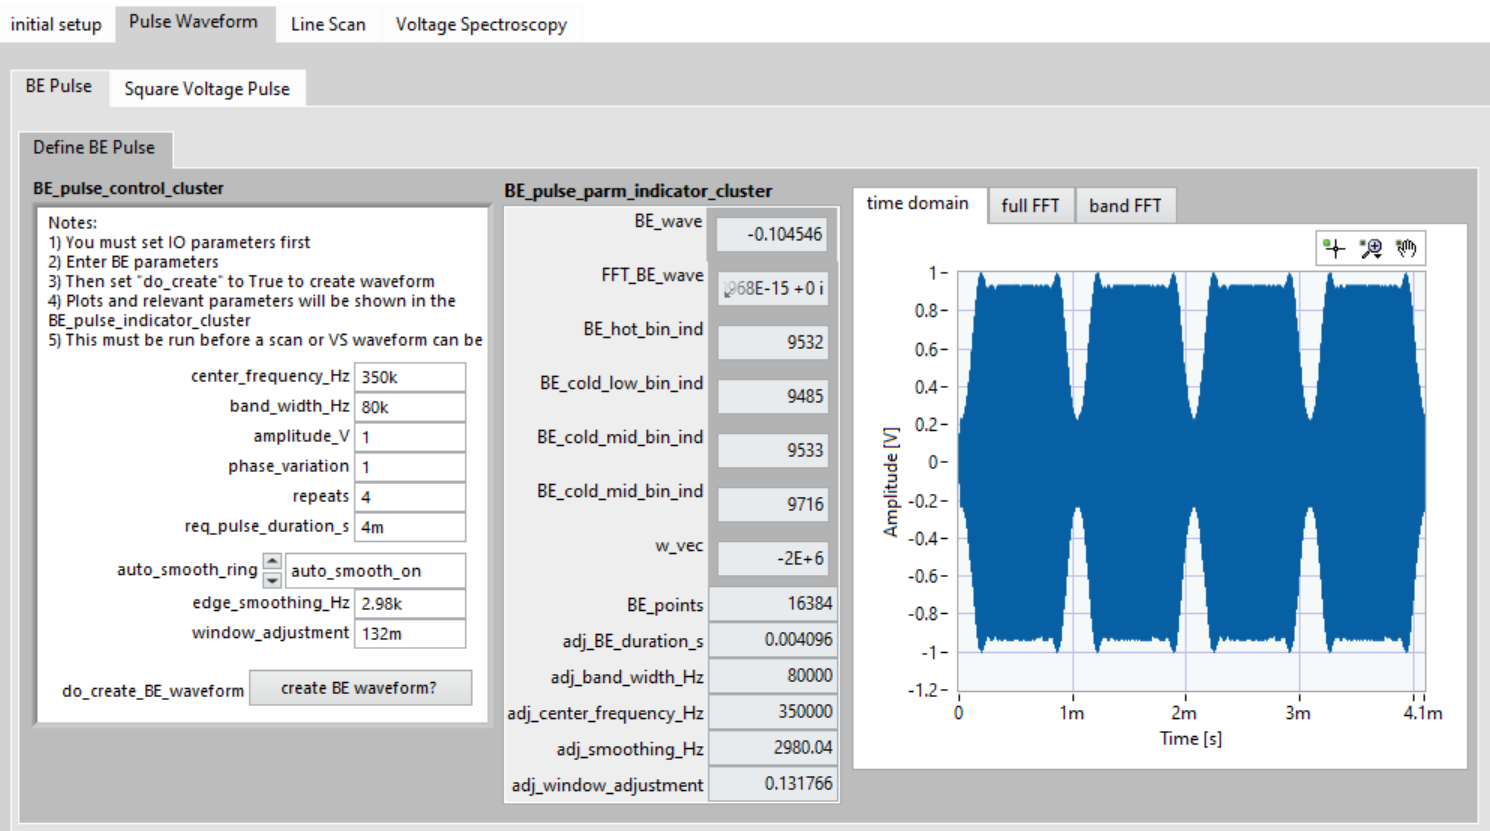

In [ ]:
# Set variables for BE parameters
center_frequency = 370  #khz
band_width = 100   #khz
drive_amplitude = 1   #V
phase_variation = 1
repeat = 4    #times
pulse_duration = 8  #ms
autosmooth = 1   #1 is on
edge_smoothhz = 2.98  #khz
window_adjustment = 200  #m

# Set BE parameters. Here each variable was set above. "True" is 'do_create_BE_waveform', 
# if we set 'do_create_BE_waveform' to "False", we will only input above parameters into PyAE
VI.setcontrolvalue('BE_pulse_control_cluster', (center_frequency*1000, band_width*1000, drive_amplitude, 
phase_variation, repeat, pulse_duration/1000, autosmooth, edge_smoothhz/1000, window_adjustment/1000, True))

# Get BE pulse cluster. We can get (and save) BE pulse parameters for post measurement analysis
be_control_para = VI.getcontrolvalue('BE_pulse_parm_indicator_cluster')
print("BE pulse parameter:\n", be_control_para)

### Set square voltage pulse

In addition to apply BE pulse to tip, we can also apply a square voltage pulse to tip. E.g., we can apply a voltage pulse via tip to switching ferroelectric polarization. 

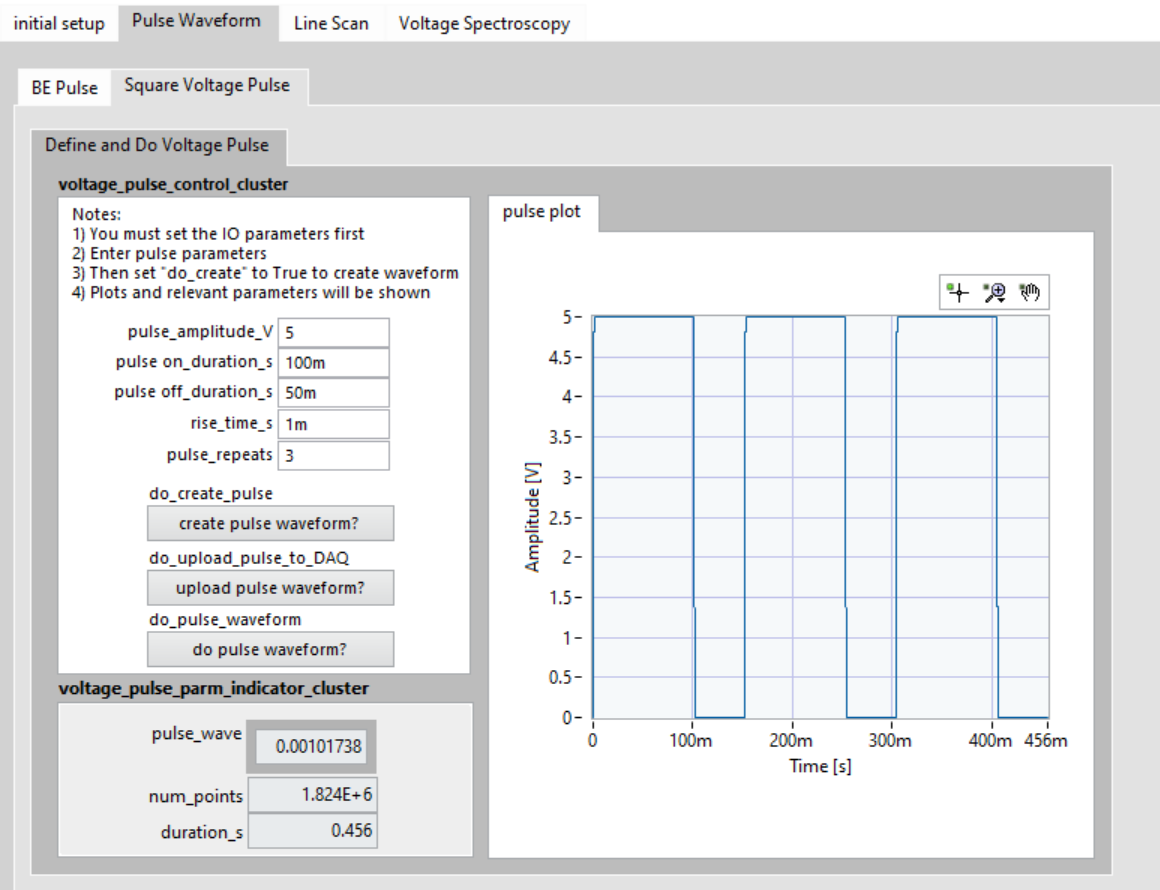

In [ ]:
# Set variables for voltage pulse parameters
pulse_amplitude = 5  #unit V
pulse_on_duration = 100/1000   #unit s
pulse_off_duration = 50/1000   #unit s
rise_time = 1/1000   #unit s
pulse_repeat = 3
create_pulse = True    # setting 'do_create_pulse' to 'True' will create a pulse will input parameters  
upload_pulse = True   # setting 'do_upload_pulse_to_DAQ' to 'True' will upload the created pulse to DAQ card
do_pulse = True    # setting 'do_pulse_waveform' to 'True' will apply the uploaded pulse in DAQ to tip

# Set BE parameters. Here each variable was set above. "True" is 'do_create_BE_waveform', 
# if we set 'do_create_BE_waveform' to "False", we will only input above parameters into PyAE
VI.setcontrolvalue('voltage_pulse_control_cluster', (pulse_amplitude, pulse_on_duration, pulse_off_duration, 
rise_time, pulse_repeat, create_pulse, upload_pulse, do_pulse))

# Get voltage pulse cluster. We can get (and save) voltage pulse parameters for post measurement analysis
voltage_pulse_parameters = VI.getcontrolvalue('voltage_pulse_parm_indicator_cluster')
print("voltage pulse parameter:\n", voltage_pulse_parameters)

## Basic Operations

### Move tip and set setpoint 

This cluster allows us to set a setpoint and move tip to a specific location. Note that the location [next_x_pos, next_y_pos] is between -1 and 1: where for next_x_pos, -1 corresponds to the left side of current image window in Igor and 1 corresponds to the right side of current image window; for next_y_pos, -1 corresponds to the bottom side and 1 corresponds to top side.

After we set a setpoint, a location [$x$, $y$], and a trainsit_time_s $t$, initializing do_move_tip will take $t$ second to move tip from current location to [$x$, $y$]

Also, setting $0$ or a negative value to setpoint is equivalent to withdraw tip

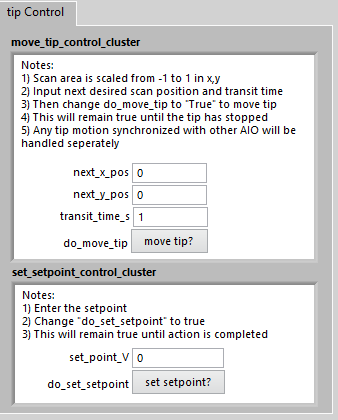


In [ ]:
# Set setpoint to 1
VI.setcontrolvalue('set_setpoint_control_cluster', (1, True))  # The number is the setpoint value
                                                               # 'True' is 'do_set_setpoint' 

In [ ]:
# Move tip to location [0.5, 0.5]
VI.setcontrolvalue('move_tip_control_cluster', (0.5, 0.5, 1, True))  # 0.5, 0.5 are next_x and next_y, respectively
                                                                     # 1 is the trainsit_time
                                                                     # 'True' is 'do_move_tip'

### BE line scan

This allows us to a BE line measurement. Note here we are just showing a single BE line measurement, for a BE image measurement, we need to create an array of locations for BE line scan. 

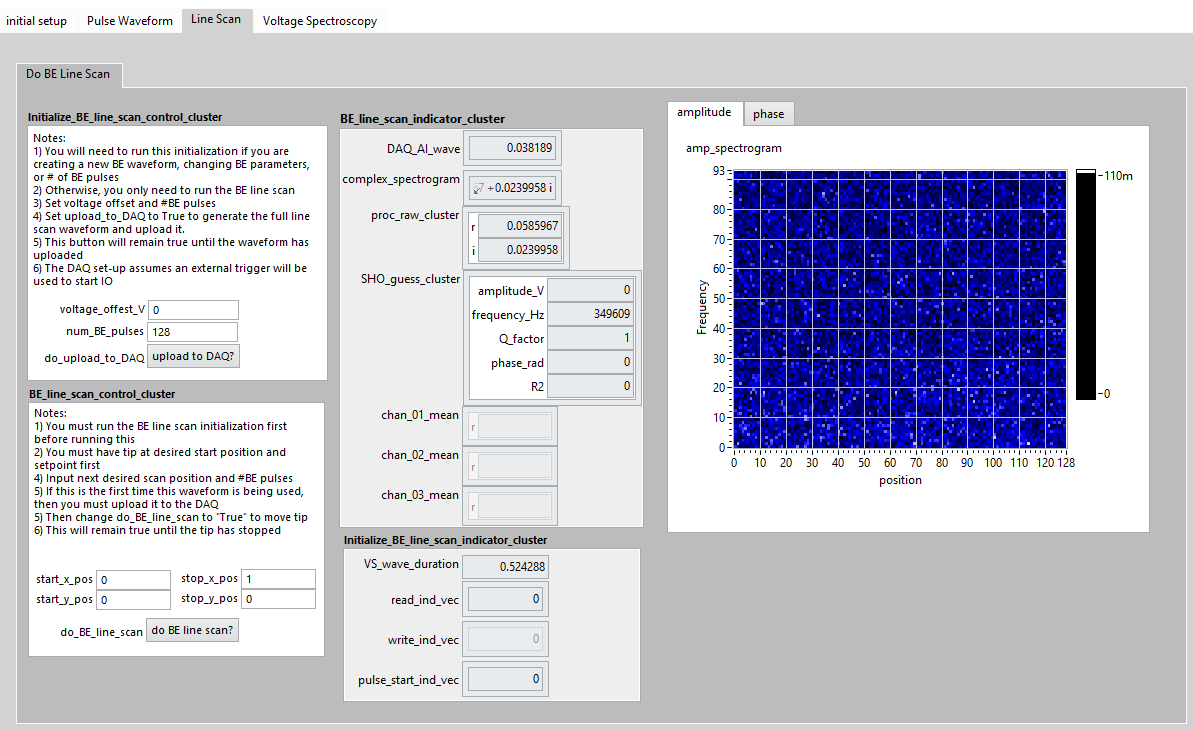

Shown below.

First we need to initialize line scan parameter:

-voltage_offset_V: a DC voltage applied to tip, ultimately the bias applied to tip will be DC offset + BE pulse. Mostly, we set voltage_offset to 0

-num_BE_pulse: number of pixels per line

-start_x_pos, start_y_pos, stop_x_pos, stop_y_pos: the BE line scan will be from the location [start_x_pos, start_y_pos] to the location [stop_x_pos, stop_y_pos]


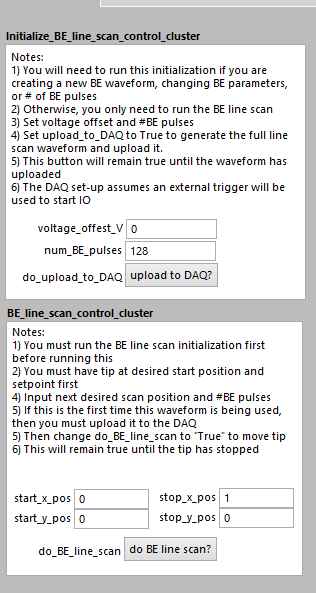

In [ ]:
# Set variables for BE line scan
voltage_offset = 0  # DC voltage applied to tip during BE line scan
pixel = 128  # number of pixel per line
upload_to_DAQ = True   # upload pixel and voltage_offset to DAQ card

start_x = 0  # scan starts at [start_x, start_y]
start_y = 0
stop_x = 1   # scan ends at [stop_x, stop_y]
stop_y = 0
BE_line = True  # do a BE line measurement

# Set voltage offset and pixel number (num_BE_pulse), and upload them to DAQ card
VI.setcontrolvalue('Initialize_BE_line_scan_control_cluster', (voltage_offset, pixel, upload_to_DAQ)) 
time.sleep (1)  # Wait a moment until voltage offset and pixel number are uploaded to DAQ  

# Set scan locations and do BE line scan
VI.setcontrolvalue('BE_line_scan_control_cluster', (start_x, start_y, stop_x, stop_y, BE_line))

# Check if BE line scan is done every 0.1 s
do_scan = VI.setcontrolvalue('BE_line_scan_control_cluster')
while do_scan[4] == True:
    time.sleep(0.1)
    do_scan = VI.setcontrolvalue('BE_line_scan_control_cluster')

# Get BE line data for post experiment analysis
BE_line_data = VI.getcontrolvalue('BE_line_scan_indicator_cluster')
print("BE line results")

In [11]:
#VI.getcontrolvalue('move_tip_control_cluster')
setpoint = 1

def move_tip (tar_x, tar_y):
    VI.setcontrolvalue('set_setpoint_control_cluster', (0, True))  #withdraw tip
    time.sleep(0.2)
    VI.setcontrolvalue('move_tip_control_cluster', (tar_x, tar_y, 1, True))  #move tip
    time.sleep(0.2)
    VI.setcontrolvalue('set_setpoint_control_cluster', (setpoint, True))  #engage
    time.sleep(0.2)
move_tip(0, 0)

In [12]:
#@title functions to scan images
def line_scan_data():
    line_data = VI.getcontrolvalue('BE_line_scan_indicator_cluster')
    daq_wave = line_data[0]
    complex_spectra = line_data[1]
    shoguessfit = line_data[3]
    topo = line_data[4]

    return daq_wave, complex_spectra, shoguessfit, topo

def scan_image(in_start_x, in_finish_x, in_start_y, in_finish_y, num_of_lines,
              num_pix, withdraw_at_end = True):
    
    parms = locals().copy()
    
    image_quick_fit = []
    image_topography = []
    complex_spectra = []
    daq_wave = []

    move_tip(in_start_x, in_start_y)
    y_range = np.linspace(in_start_y, in_finish_y, num_of_lines)
    for i in range (num_of_lines):
        scan_start_x  = in_start_x
        scan_finish_x = in_finish_x
        scan_start_y  = y_range[i]
        scan_finish_y = y_range[i]
        next_x_start  = in_start_x
        next_y_start  = y_range[int((i+1)%num_of_lines)]
#         time.sleep(0.5)
        VI.setcontrolvalue('BE_line_scan_control_cluster', 
        (scan_start_x, scan_start_y, scan_finish_x, scan_finish_y, True))
        time.sleep(1.0)
        
        raw_daq_wave, raw_complex_spectra, sho_quick_fit, topogra = line_scan_data()
        if len(sho_quick_fit) == 0:
            print('QF returned an empty array on {}th line'.format(i))
            break
        image_quick_fit.append(np.asarray(sho_quick_fit))
        image_topography.append(topogra)
        complex_spectra.append(np.asarray(raw_complex_spectra))
#         daq_wave.append(np.asarray(raw_daq_wave).reshape([num_pix, -1]))
        
        move_tip(next_x_start, next_y_start)
        time.sleep(0.25)
    
    if withdraw_at_end: #set setpoint to -1
        VI.setcontrolvalue('set_setpoint_control_cluster', (0.1, True))  #Withdraw the tip
        
    
    return daq_wave, complex_spectra, image_quick_fit, image_topography, parms

In [13]:
#@title Function to save results as sidpy datasets

def make_dsets(qf, cs, local_parms, scan_size_x = 2, scan_size_y = 2, fit = True):
    
    qf_array = np.nan_to_num(np.array(qf))
    
    lines, pix = qf_array.shape[0], qf_array.shape[1]
    
    dset_qf = sid.Dataset.from_array(qf_array, title = 'Quick_fit_stack')
    dset_qf.data_type = 'image_stack'
    dset_qf.quantity = 'fast_fit_parameters'
    
    strt_x = local_parms['in_start_x'] 
    fnsh_x = local_parms['in_finish_x']
    strt_y = local_parms['in_start_y']
    fnsh_y = local_parms['in_finish_y']

    xlen = np.abs(fnsh_x - strt_x)
    ylen = np.abs(fnsh_y - strt_y)

    dset_qf.set_dimension(0, sid.Dimension(np.linspace(0,1,dset_qf.shape[0])*((scan_size_y*ylen)/2),
                                        name = 'Y',units = 'm',
                                        quantity = 'Y',
                                        dimension_type = 'spatial'))



    dset_qf.set_dimension(1, sid.Dimension(np.linspace(0,1,dset_qf.shape[1])*((scan_size_x*xlen)/2),
                                        name = 'X',units = 'm',
                                        quantity = 'X',
                                        dimension_type = 'spatial'))

    dset_qf.set_dimension(2, sid.Dimension(np.arange(dset_qf.shape[2]),
                                        name = 'C',
                                        quantity = 'channels',
                                        dimension_type = 'frame'))
    
    
    fft_frequencies = np.asarray(VI.getcontrolvalue('BE_pulse_parm_indicator_cluster')[7])
    fft_bin_indices = np.asarray(VI.getcontrolvalue('BE_pulse_parm_indicator_cluster')[3])

    #Channel names
    cs_arr = np.zeros([np.array(qf).shape[0], np.array(qf).shape[1], len(fft_frequencies[fft_bin_indices]), 2])
    
    for ind in range(len(cs)):
        try:
            cs_arr[ind] = cs[ind]
        except:
            cs_arr[ind] = 0.0
#             print(cs_arr[ind].shape)
#             print(cs[ind].shape)
            cs_arr[ind, :, 0:(cs[ind].shape[1]), :] = cs[ind]
        
#     cs_arr = np.asarray(cs)
    dset_cs = sid.Dataset.from_array(cs_arr[...,0] + 1j*cs_arr[...,1], title = 'complex_spectra')
    dset_cs.quantity = 'pfm_response'
    dset_cs.units = 'V'

    dset_cs.set_dimension(0, sid.Dimension(np.linspace(0,1,dset_qf.shape[0])*((scan_size_y*ylen)/2),
                                        name = 'Y',units = 'm',
                                        quantity = 'Y',
                                        dimension_type = 'spatial'))


    dset_cs.set_dimension(1, sid.Dimension(np.arange(dset_cs.shape[1]),
                                        name = 'X', units = 'm',
                                        quantity = 'X',
                                        dimension_type = 'spatial'))

   
    dset_cs.set_dimension(2, sid.Dimension(fft_frequencies[fft_bin_indices],
                                        name = 'nu', units = 'Hz',
                                        quantity = 'frequncy_bins',
                                        dimension_type = 'spectral'))
    
    if fit:
        
        wv = (fft_frequencies[fft_bin_indices])
        out = Parallel(n_jobs = 16)(delayed(do_fit)(k,cs_arr,qf_array, wv) for k in range(lines*pix))

        fit_dset = (np.asarray(out).reshape([lines, pix, -1]))
        
        #Making the dataset
        dset_shofit = sid.Dataset.from_array(fit_dset, title = 'SHO_fit_parms')
        dset_shofit.data_type = 'image_stack'
        dset_shofit.quantity = 'SHO_fit_parms'
        
        dset_shofit.set_dimension(0, sid.Dimension(np.linspace(0,1,fit_dset.shape[0])*((scan_size_y*ylen)/2),
                                        name = 'Y',units = 'm',
                                        quantity = 'Y',
                                        dimension_type = 'spatial'))



        dset_shofit.set_dimension(1, sid.Dimension(np.linspace(0,1,fit_dset.shape[1])*((scan_size_x*xlen)/2),
                                            name = 'X',units = 'm',
                                            quantity = 'X',
                                            dimension_type = 'spatial'))

        dset_shofit.set_dimension(2, sid.Dimension(np.arange(fit_dset.shape[2]),
                                            name = 'C',
                                            quantity = 'channels',
                                            dimension_type = 'frame'))

        dsets = [dset_qf, dset_cs, dset_shofit]
    else:
        dsets = [dset_qf, dset_cs]

    #Setting the metadata

    for dset in dsets:
        for i, val in enumerate(igor_para):
            dset.original_metadata[i] = val

        #Setting the metadata corresponding to the parms of the scan_image function
        dset.metadata.update(local_parms)
        dset.metadata['voltage_offset'] = voltage_offset
        dset.metadata['pixels'] = pix
        dset.metadata['setpoint'] = setpoint

        #BE Parameters
        BE_parms_names = ['center_frequency_Hz', 'band_width_Hz', 'amplitude_V',
                         'phase_variation', 'repeats', 'req_pulse_duration_s', 
                         'auto_smooth_ring', 'edge_smoothing_Hz', 'window_adjustment']
        BE_parms_values = VI.getcontrolvalue('BE_pulse_control_cluster')
        dset.metadata['BE_parms'] = {}
        for i, name in enumerate(BE_parms_names):
            dset.metadata['BE_parms'][name] = BE_parms_values[i]


        #IO Parameters
        IO_indicator_cluster_names = ['IO_AFM_platform', 'IO_card', 'IO_rate', 'IA_AO_range', 'Analog_output_rating',
                                     'IO_AI range', 'analog_output_amplifier', 'IO_Channel_011_type',
                                     'IO_Channel_012_type', 'IO_Channel_013_type']
        IO_indicator_cluster_values = VI.getcontrolvalue('IO_indicator_cluster')    
        dset.metadata['IO_indicator_parms'] = {}
        for i, name in enumerate(IO_indicator_cluster_names):
            dset.metadata['IO_indicator_parms'][name] = IO_indicator_cluster_values[i]

        dset.metadata['VS_wave_duration'] = VI.getcontrolvalue('Initialize_BE_line_scan_indicator_cluster')[0]

        dset.metadata['Bias_Parms'] = {}
        Bias_Parms_names = ['pulse_amp_V', 'pulse_on_duration_s', 'pulse_off_duration_s',
                                             'rise_time_s', 'pulse_repeats']
        Bias_Parms_values = VI.getcontrolvalue('voltage_pulse_control_cluster')
        
        for i, name in enumerate(Bias_Parms_names):
            dset.metadata['Bias_Parms'][name] = Bias_Parms_names[i]
        
    
    if fit:
        return [dset_qf, dset_cs, dset_shofit]
    else:
        return [dset_qf, dset_cs]

Set BE parameters

In [14]:
center_frequency = 370  #khz
band_width = 100   #khz
drive_amplitude = 1   #V
phase_variation = 1
repeat = 4    #times
pulse_duration = 8  #ms
autosmooth = 1   #1 is on
edge_smoothhz = 2.98  #khz
window_adjustment = 200  #m

#set BE parameters
VI.setcontrolvalue('BE_pulse_control_cluster', (center_frequency*1000, band_width*1000, drive_amplitude, 
phase_variation, repeat, pulse_duration/1000, autosmooth, edge_smoothhz/1000, window_adjustment/1000, True))

#get BE parameters
be_control_para = VI.getcontrolvalue('BE_pulse_parm_indicator_cluster')
be_control_para

((-0.06611511093449848,
  -0.03982082733254329,
  -0.0032292987866316485,
  0.03167394076082415,
  0.054228773156451,
  0.05846552215948632,
  0.044718834959667816,
  0.01904498074035091,
  -0.009231514099654482,
  -0.03089156536512949,
  -0.03989935510033715,
  -0.03513924620431136,
  -0.02029686680445627,
  -0.002056151368604685,
  0.012623510411800782,
  0.019096448403194913,
  0.0165389640375905,
  0.007878312494668773,
  -0.0017405149574532025,
  -0.007283267290809931,
  -0.006001180454218706,
  0.0014120882013008477,
  0.011132163873760726,
  0.017853654659663012,
  0.01711875801189747,
  0.007390336215820749,
  -0.008982184029742334,
  -0.026343485499480773,
  -0.03770923739946232,
  -0.03744104030327283,
  -0.023622121970641605,
  0.0007966242196074017,
  0.028593293266973064,
  0.05050419643616498,
  0.0583694032365991,
  0.04811043268347192,
  0.02146601687275429,
  -0.01419322206262767,
  -0.04800109475883445,
  -0.06903286784744816,
  -0.06991986426262294,
  -0.049422585659

In [15]:
beps_parms = VI.getcontrolvalue('Initialize_BEPS_VS_control_cluster')  #withdraw the tip


beps_amp = 7
offset_v = 0
steps_per_cycle = 64
read_voltage = 0
num_cycles = 2
cycle_fraction = 0 #0 = full
cycle_phase_shift = 0
measure_loops = 2 #2='on and off field'
transition_time = 0.001
delay_after_step = 0


print(beps_parms)
VI.setcontrolvalue('Initialize_BEPS_VS_control_cluster', (beps_amp, offset_v, read_voltage , steps_per_cycle,
                  num_cycles, cycle_fraction, cycle_phase_shift, measure_loops, transition_time, delay_after_step,
                         1,0,8,8,7,-7,0,0,True, True, False))  #upload BEPS parms

beps_parms = VI.getcontrolvalue('Initialize_BEPS_VS_control_cluster')  #withdraw the tip
print(beps_parms)
time.sleep(0.2)
VI.setcontrolvalue('Initialize_BEPS_VS_control_cluster', (beps_amp, offset_v, read_voltage , steps_per_cycle,
                  num_cycles, cycle_fraction, cycle_phase_shift, measure_loops, transition_time, delay_after_step,
                         1,0,8,8,7,-7,0,0,True, True, True))  #upload BEPS parms



(6.0, 0.0, 0.0, 32, 1, 0, 0, 2, 0.001, 0.0, 1, 0, 8.0, 8.0, 7.0, -7.0, 0.0, 0.0, False, False, False)
(7.0, 0.0, 0.0, 64, 2, 0, 0, 2, 0.001, 0.0, 1, 0, 8.0, 8.0, 7.0, -7.0, 0.0, 0.0, True, True, False)


In [15]:
move_tip(0.3,0.1)

In [48]:
%matplotlib inline

In [39]:
beps_grid_data = []

num_loops = 2500 #must be square

loc_x = np.linspace(-1,1,int(np.sqrt(num_loops)))
loc_y = np.linspace(-1,1,int(np.sqrt(num_loops)))

for ind_x in range(int(np.sqrt(num_loops))):
    for ind_y in range(int(np.sqrt(num_loops))):

        print('Capturing loop at position {},{}'.format(ind_x, ind_y))
          
        #move tip
        move_tip(loc_x[ind_x], loc_y[ind_y])
        time.sleep(0.2)

        #Do BEPS
        VI.setcontrolvalue('Initialize_BEPS_VS_control_cluster', (beps_amp, offset_v, read_voltage , steps_per_cycle,
                      num_cycles, cycle_fraction, cycle_phase_shift, measure_loops, transition_time, delay_after_step,
                             1,0,8,8,7,-7,0,0,True, True, False))  #upload BEPS parms
        time.sleep(0.1)
        VI.setcontrolvalue('Initialize_BEPS_VS_control_cluster', (beps_amp, offset_v, read_voltage , steps_per_cycle,
                      num_cycles, cycle_fraction, cycle_phase_shift, measure_loops, transition_time, delay_after_step,
                             1,0,8,8,7,-7,0,0,True, True, True))  #upload BEPS parms

        #check to see if done
        done_parms = VI.getcontrolvalue('Initialize_BEPS_VS_control_cluster')[-1]

        while done_parms is True:
            done_parms = VI.getcontrolvalue('Initialize_BEPS_VS_control_cluster')[-1]
            time.sleep(0.25)

        data=VI.getcontrolvalue('BEPS_VS_indicator_cluster')
        
        beps_grid_data.append([(loc_x[ind_x], loc_y[ind_y]), data])
        
        

Capturing loop at position 0,0
Capturing loop at position 0,1
Capturing loop at position 0,2
Capturing loop at position 0,3
Capturing loop at position 0,4
Capturing loop at position 0,5
Capturing loop at position 0,6
Capturing loop at position 0,7
Capturing loop at position 0,8
Capturing loop at position 0,9
Capturing loop at position 0,10
Capturing loop at position 0,11
Capturing loop at position 0,12
Capturing loop at position 0,13
Capturing loop at position 0,14
Capturing loop at position 0,15
Capturing loop at position 0,16
Capturing loop at position 0,17
Capturing loop at position 0,18
Capturing loop at position 0,19
Capturing loop at position 0,20
Capturing loop at position 0,21
Capturing loop at position 0,22
Capturing loop at position 0,23
Capturing loop at position 0,24
Capturing loop at position 0,25
Capturing loop at position 0,26
Capturing loop at position 0,27
Capturing loop at position 0,28
Capturing loop at position 0,29
Capturing loop at position 0,30
Capturing loop at 

Capturing loop at position 5,8
Capturing loop at position 5,9
Capturing loop at position 5,10
Capturing loop at position 5,11
Capturing loop at position 5,12
Capturing loop at position 5,13
Capturing loop at position 5,14
Capturing loop at position 5,15
Capturing loop at position 5,16
Capturing loop at position 5,17
Capturing loop at position 5,18
Capturing loop at position 5,19
Capturing loop at position 5,20
Capturing loop at position 5,21
Capturing loop at position 5,22
Capturing loop at position 5,23
Capturing loop at position 5,24
Capturing loop at position 5,25
Capturing loop at position 5,26
Capturing loop at position 5,27
Capturing loop at position 5,28
Capturing loop at position 5,29
Capturing loop at position 5,30
Capturing loop at position 5,31
Capturing loop at position 5,32
Capturing loop at position 5,33
Capturing loop at position 5,34
Capturing loop at position 5,35
Capturing loop at position 5,36
Capturing loop at position 5,37
Capturing loop at position 5,38
Capturing 

Capturing loop at position 10,16
Capturing loop at position 10,17
Capturing loop at position 10,18
Capturing loop at position 10,19
Capturing loop at position 10,20
Capturing loop at position 10,21
Capturing loop at position 10,22
Capturing loop at position 10,23
Capturing loop at position 10,24
Capturing loop at position 10,25
Capturing loop at position 10,26
Capturing loop at position 10,27
Capturing loop at position 10,28
Capturing loop at position 10,29
Capturing loop at position 10,30
Capturing loop at position 10,31
Capturing loop at position 10,32
Capturing loop at position 10,33
Capturing loop at position 10,34
Capturing loop at position 10,35
Capturing loop at position 10,36
Capturing loop at position 10,37
Capturing loop at position 10,38
Capturing loop at position 10,39
Capturing loop at position 10,40
Capturing loop at position 10,41
Capturing loop at position 10,42
Capturing loop at position 10,43
Capturing loop at position 10,44
Capturing loop at position 10,45
Capturing 

Capturing loop at position 15,16
Capturing loop at position 15,17
Capturing loop at position 15,18
Capturing loop at position 15,19
Capturing loop at position 15,20
Capturing loop at position 15,21
Capturing loop at position 15,22
Capturing loop at position 15,23
Capturing loop at position 15,24
Capturing loop at position 15,25
Capturing loop at position 15,26
Capturing loop at position 15,27
Capturing loop at position 15,28
Capturing loop at position 15,29
Capturing loop at position 15,30
Capturing loop at position 15,31
Capturing loop at position 15,32
Capturing loop at position 15,33
Capturing loop at position 15,34
Capturing loop at position 15,35
Capturing loop at position 15,36
Capturing loop at position 15,37
Capturing loop at position 15,38
Capturing loop at position 15,39
Capturing loop at position 15,40
Capturing loop at position 15,41
Capturing loop at position 15,42
Capturing loop at position 15,43
Capturing loop at position 15,44
Capturing loop at position 15,45
Capturing 

Capturing loop at position 20,16
Capturing loop at position 20,17
Capturing loop at position 20,18
Capturing loop at position 20,19
Capturing loop at position 20,20
Capturing loop at position 20,21
Capturing loop at position 20,22
Capturing loop at position 20,23
Capturing loop at position 20,24
Capturing loop at position 20,25
Capturing loop at position 20,26
Capturing loop at position 20,27
Capturing loop at position 20,28
Capturing loop at position 20,29
Capturing loop at position 20,30
Capturing loop at position 20,31
Capturing loop at position 20,32
Capturing loop at position 20,33
Capturing loop at position 20,34
Capturing loop at position 20,35
Capturing loop at position 20,36
Capturing loop at position 20,37
Capturing loop at position 20,38
Capturing loop at position 20,39
Capturing loop at position 20,40
Capturing loop at position 20,41
Capturing loop at position 20,42
Capturing loop at position 20,43
Capturing loop at position 20,44
Capturing loop at position 20,45
Capturing 

Capturing loop at position 25,16
Capturing loop at position 25,17
Capturing loop at position 25,18
Capturing loop at position 25,19
Capturing loop at position 25,20
Capturing loop at position 25,21
Capturing loop at position 25,22
Capturing loop at position 25,23
Capturing loop at position 25,24
Capturing loop at position 25,25
Capturing loop at position 25,26
Capturing loop at position 25,27
Capturing loop at position 25,28
Capturing loop at position 25,29
Capturing loop at position 25,30
Capturing loop at position 25,31
Capturing loop at position 25,32
Capturing loop at position 25,33
Capturing loop at position 25,34
Capturing loop at position 25,35
Capturing loop at position 25,36
Capturing loop at position 25,37
Capturing loop at position 25,38
Capturing loop at position 25,39
Capturing loop at position 25,40
Capturing loop at position 25,41
Capturing loop at position 25,42
Capturing loop at position 25,43
Capturing loop at position 25,44
Capturing loop at position 25,45
Capturing 

Capturing loop at position 30,16
Capturing loop at position 30,17
Capturing loop at position 30,18
Capturing loop at position 30,19
Capturing loop at position 30,20
Capturing loop at position 30,21
Capturing loop at position 30,22
Capturing loop at position 30,23
Capturing loop at position 30,24
Capturing loop at position 30,25
Capturing loop at position 30,26
Capturing loop at position 30,27
Capturing loop at position 30,28
Capturing loop at position 30,29
Capturing loop at position 30,30
Capturing loop at position 30,31
Capturing loop at position 30,32
Capturing loop at position 30,33
Capturing loop at position 30,34
Capturing loop at position 30,35
Capturing loop at position 30,36
Capturing loop at position 30,37
Capturing loop at position 30,38
Capturing loop at position 30,39
Capturing loop at position 30,40
Capturing loop at position 30,41
Capturing loop at position 30,42
Capturing loop at position 30,43
Capturing loop at position 30,44
Capturing loop at position 30,45
Capturing 

Capturing loop at position 35,16
Capturing loop at position 35,17
Capturing loop at position 35,18
Capturing loop at position 35,19
Capturing loop at position 35,20
Capturing loop at position 35,21
Capturing loop at position 35,22
Capturing loop at position 35,23
Capturing loop at position 35,24
Capturing loop at position 35,25
Capturing loop at position 35,26
Capturing loop at position 35,27
Capturing loop at position 35,28
Capturing loop at position 35,29
Capturing loop at position 35,30
Capturing loop at position 35,31
Capturing loop at position 35,32
Capturing loop at position 35,33
Capturing loop at position 35,34
Capturing loop at position 35,35
Capturing loop at position 35,36
Capturing loop at position 35,37
Capturing loop at position 35,38
Capturing loop at position 35,39
Capturing loop at position 35,40
Capturing loop at position 35,41
Capturing loop at position 35,42
Capturing loop at position 35,43
Capturing loop at position 35,44
Capturing loop at position 35,45
Capturing 

Capturing loop at position 40,16
Capturing loop at position 40,17
Capturing loop at position 40,18
Capturing loop at position 40,19
Capturing loop at position 40,20
Capturing loop at position 40,21
Capturing loop at position 40,22
Capturing loop at position 40,23
Capturing loop at position 40,24
Capturing loop at position 40,25
Capturing loop at position 40,26
Capturing loop at position 40,27
Capturing loop at position 40,28
Capturing loop at position 40,29
Capturing loop at position 40,30
Capturing loop at position 40,31
Capturing loop at position 40,32
Capturing loop at position 40,33
Capturing loop at position 40,34
Capturing loop at position 40,35
Capturing loop at position 40,36
Capturing loop at position 40,37
Capturing loop at position 40,38
Capturing loop at position 40,39
Capturing loop at position 40,40
Capturing loop at position 40,41
Capturing loop at position 40,42
Capturing loop at position 40,43
Capturing loop at position 40,44
Capturing loop at position 40,45
Capturing 

Capturing loop at position 45,16
Capturing loop at position 45,17
Capturing loop at position 45,18
Capturing loop at position 45,19
Capturing loop at position 45,20
Capturing loop at position 45,21
Capturing loop at position 45,22
Capturing loop at position 45,23
Capturing loop at position 45,24
Capturing loop at position 45,25
Capturing loop at position 45,26
Capturing loop at position 45,27
Capturing loop at position 45,28
Capturing loop at position 45,29
Capturing loop at position 45,30
Capturing loop at position 45,31
Capturing loop at position 45,32
Capturing loop at position 45,33
Capturing loop at position 45,34
Capturing loop at position 45,35
Capturing loop at position 45,36
Capturing loop at position 45,37
Capturing loop at position 45,38
Capturing loop at position 45,39
Capturing loop at position 45,40
Capturing loop at position 45,41
Capturing loop at position 45,42
Capturing loop at position 45,43
Capturing loop at position 45,44
Capturing loop at position 45,45
Capturing 

In [59]:


amp_slices = []

for ind in range(len(beps_grid_data)):
    amp_slices.append(beps_grid_data[ind][1][2])
amp_slices = np.array(amp_slices)

'''
fig, axes = plt.subplots(nrows=10, ncols=10, figsize = (15,10), sharex=True)
for ind, ax in enumerate(axes.flat):
    ax.plot(beps_grid_data[ind*25][1][0][-64:], beps_grid_data[ind*25][1][2][1::2][-64:],'r-')
    ax.axis('off')
    #ax2 = ax.twinx()
    #ax2.axis('off')
    #ax2.plot(beps_grid_data[ind*25][1][0], beps_grid_data[ind*25][1][5][1::2],'g-')
fig.tight_layout()'''


"\nfig, axes = plt.subplots(nrows=10, ncols=10, figsize = (15,10), sharex=True)\nfor ind, ax in enumerate(axes.flat):\n    ax.plot(beps_grid_data[ind*25][1][0][-64:], beps_grid_data[ind*25][1][2][1::2][-64:],'r-')\n    ax.axis('off')\n    #ax2 = ax.twinx()\n    #ax2.axis('off')\n    #ax2.plot(beps_grid_data[ind*25][1][0], beps_grid_data[ind*25][1][5][1::2],'g-')\nfig.tight_layout()"

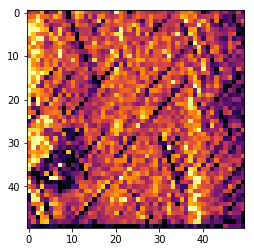

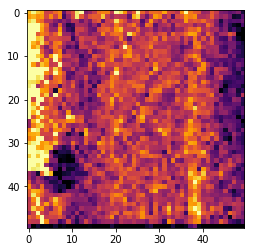

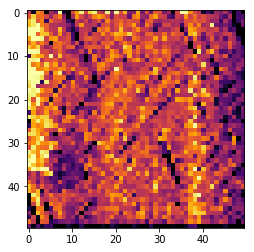

In [70]:

for slice_val in [16,32,48]:
    plt.figure()
    #slice_val = 16
    vmin = amp_slices[:,slice_val ].mean()-2* amp_slices[:,slice_val ].std()
    vmax = amp_slices[:,slice_val ].mean()+2* amp_slices[:,slice_val ].std()
    plt.imshow(np.rot90(amp_slices[:,slice_val ].reshape(50,50)),cmap='inferno', vmin = vmin, vmax = vmax)

In [47]:
import pickle

results = {'results_beps': beps_grid_data}
pickle.dump( results, open(r"beps_data_50x50.p", "wb"))

In [41]:
VI.setcontrolvalue('set_setpoint_control_cluster', (-1, True))  #withdraw the tip

pix = 32
num_of_lines = 8
voltage_offset = 0

VI.setcontrolvalue('Initialize_BE_line_scan_control_cluster', (voltage_offset, pix, True))
time.sleep(0.1)
VI.setcontrolvalue('Initialize_BE_line_scan_control_cluster', (voltage_offset, pix, True))

start_x = -1;   finish_x = 1
start_y = -1;   finish_y = 1
daq, cs, qf, topo, local_parms = scan_image(start_x, finish_x, start_y, finish_y, num_of_lines, pix)

[(-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, -1.0, 1.0, -1.0, True), (-1.0, 

[(-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True), (-1.0, -0.7142857142857143, 1.0, True),

[(-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857143, 1.0, -0.7142857142857143, True), (-1.0, -0.7142857142857

[(-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True), (-1.0, -0.4285714285714286, 1.0, True),

[(-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714286, 1.0, -0.4285714285714286, True), (-1.0, -0.4285714285714

[(-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True), (-1.0, -0.1428571428571429, 1.0, True),

[(-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571429, 1.0, -0.1428571428571429, True), (-1.0, -0.1428571428571

[(-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.1428571428571428, 1.0, True), (-1.0, 0.142857142857142

[(-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, True), (-1.0, 0.1428571428571428, 1.0, 0.1428571428571428, Tru

[(-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.4285714285714284, 1.0, True), (-1.0, 0.428571428571428

[(-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, True), (-1.0, 0.4285714285714284, 1.0, 0.4285714285714284, Tru

[(-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.7142857142857142, 1.0, True), (-1.0, 0.714285714285714

[(-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, True), (-1.0, 0.7142857142857142, 1.0, 0.7142857142857142, Tru

[(-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0

[(-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1.0, 1.0, True), (-1.0, 1.0, 1

[(-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True), (-1.0, -1.0, 1.0, True),

In [17]:
qqf = np.asarray(qf)
t = np.asarray(topo)
t.shape

(0,)

In [18]:
qqf = np.asarray(qf)
qqf.shape

plt.figure()
plt.imshow(qqf[:,:,0], origin = 'lower')
plt.colorbar()
# for line, wall_pos in enumerate(ini_walls):
#     plt.scatter(wall_pos, line, c = 'r', s = 1)


plt.figure()
plt.imshow(qqf[:,:,1], origin = 'lower')
plt.colorbar()
# for line, wall_pos in enumerate(ini_walls):
#     plt.scatter(wall_pos, line, c = 'r', s = 1)

plt.figure()
plt.imshow(qqf[:,:,2], origin = 'lower')
plt.colorbar()
# for line, wall_pos in enumerate(ini_walls):
#     plt.scatter(wall_pos, line, c = 'r', s = 1)

plt.figure()
plt.imshow(qqf[:,:,3], origin = 'lower')
plt.colorbar()
# for line, wall_pos in enumerate(ini_walls):
#     plt.scatter(wall_pos, line, c = 'r', s = 1)

plt.figure()
plt.imshow(qqf[:,:,4], origin = 'lower')
plt.colorbar()

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

<Figure size 432x288 with 0 Axes>

In [39]:
tip_is_move = VI.getcontrolvalue('move_tip_control_cluster')
tip_is_move[3]

False

In [40]:
def scan_image(in_start_x, in_finish_x, in_start_y, in_finish_y, num_of_lines,
              num_pix, withdraw_at_end = True):
    
    parms = locals().copy()
    
    image_quick_fit = []
    image_topography = []
    complex_spectra = []
    daq_wave = []

    move_tip(in_start_x, in_start_y)
    y_range = np.linspace(in_start_y, in_finish_y, num_of_lines)
    t0 = time.time()
    for i in range (num_of_lines):
        scan_start_x  = in_start_x
        scan_finish_x = in_finish_x
        scan_start_y  = y_range[i]
        scan_finish_y = y_range[i]
        next_x_start  = in_start_x
        next_y_start  = y_range[int((i+1)%num_of_lines)]
#         time.sleep(0.5)
        VI.setcontrolvalue('BE_line_scan_control_cluster', 
        (scan_start_x, scan_start_y, scan_finish_x, scan_finish_y, True))
    
        do_scan = VI.getcontrolvalue('BE_line_scan_control_cluster')
        rec = []
        rec.append(do_scan)
        while do_scan[4]==True:
            do_scan = VI.getcontrolvalue('BE_line_scan_control_cluster')
            rec.append(do_scan)
            
        print(rec)   
#         time.sleep(1.0)
        
        raw_daq_wave, raw_complex_spectra, sho_quick_fit, topogra = line_scan_data()
        if len(sho_quick_fit) == 0:
            print('QF returned an empty array on {}th line'.format(i))
            break
        image_quick_fit.append(np.asarray(sho_quick_fit))
        image_topography.append(topogra)
        complex_spectra.append(np.asarray(raw_complex_spectra))
#         daq_wave.append(np.asarray(raw_daq_wave).reshape([num_pix, -1]))
        
        t0 = time.time()
        move_tip(next_x_start, next_y_start)
        tip_is_move = VI.getcontrolvalue('move_tip_control_cluster')
        rec = []
        rec.append(tip_is_move)
        while tip_is_move[3]==True:
            tip_is_move = VI.getcontrolvalue('move_tip_control_cluster')
            rec.append(tip_is_move)
            
        print(rec)   
#         time.sleep(0.25)
    
    if withdraw_at_end: #set setpoint to -1
        VI.setcontrolvalue('set_setpoint_control_cluster', (0.1, True))  #Withdraw the tip
        
    
    return daq_wave, complex_spectra, image_quick_fit, image_topography, parms

In [ ]:
plt.plot(qqf[210, :, 3])

In [ ]:
ini_dsets = make_dsets(qf, cs, local_parms, 1.5, 1.5, fit = True)

In [ ]:
from scipy.optimize import curve_fit
def sigmoid(x, *parms):
    a,b,Offset = parms
    return 1.0 / (1.0 + np.exp(-1.0 * a * (x - b))) + Offset

def rev_sigmoid(x, *parms):
    a,b,Offset = parms
    return np.exp(-1.0 * a * (x - b)) / (1.0 + np.exp(-1.0 * a * (x - b))) + Offset


def norm_image(arr):
    return (arr - np.amin(arr))/(np.ptp(arr))


def get_sigmoid_wall(phase_profile, clip_inds = [40, 80],
                     ind = None):
    
    
    # First just normalize the phase profile
#     phase_profile_norm = norm_image(phase_profile)
        
    
    if clip_inds is None:
        clip_inds = [0, phase_profile.shape[1]]
    
    
    phase_cons = phase_profile[:, clip_inds[0]:clip_inds[1]]
    xvals = np.arange(clip_inds[0], clip_inds[1])
    prior_b = (clip_inds[0] + clip_inds[1])/2
    
    if ind is None:
        wall_pos, wall_width = [], []
        for j in range(phase_cons.shape[0]):
            try:
                yvals = (phase_cons[j] - np.amin(phase_cons[j])) / np.ptp(phase_cons[j])
                fit_values = curve_fit(sigmoid, xvals, yvals, p0 = [0.75, prior_b, 0], maxfev = 10000)
    #                 wall_pos.append(prior_b)
                
                if fit_values[0][1]>=clip_inds[0] and fit_values[0][1]<=clip_inds[1]:
                    wall_pos.append(fit_values[0][1])
                    wall_width.append(fit_values[0][0])
                else:
                    wall_pos.append((clip_inds[0] + clip_inds[1])/2)
                    wall_width.append(0)
                    
            
            except:
#                 print(j)
                print('Im here')
                wall_pos.append(0)
                wall_width.append(0)
            
    else:
        try:
            yvals = (phase_cons[ind] - np.amin(phase_cons[ind])) / np.ptp(phase_cons[ind])
            fit_values = curve_fit(sigmoid, xvals, yvals, p0 = [0.75, prior_b, 0], maxfev = 10000)
            
            wall_pos = fit_values[0][1]
            wall_width = (fit_values[0][0])
#             print(fit_values)
        except:
            print('Im not there')
            wall_pos, wall_width = 0,0
    return wall_pos, wall_width

In [ ]:
ini_walls, _ = get_sigmoid_wall(np.asarray(qf)[:,:,3], clip_inds = [50, 200])
ini_walls

In [ ]:
len(ini_walls)

In [ ]:
qqf = np.asarray(qf)
qqf.shape

plt.figure()
plt.imshow(qqf[:,:,0], origin = 'lower')
plt.colorbar()
for line, wall_pos in enumerate(ini_walls):
    plt.scatter(wall_pos, line, c = 'r', s = 1)


plt.figure()
plt.imshow(qqf[:,:,1], origin = 'lower')
plt.colorbar()
for line, wall_pos in enumerate(ini_walls):
    plt.scatter(wall_pos, line, c = 'r', s = 1)

plt.figure()
plt.imshow(qqf[:,:,2], origin = 'lower')
plt.colorbar()
for line, wall_pos in enumerate(ini_walls):
    plt.scatter(wall_pos, line, c = 'r', s = 1)

plt.figure()
plt.imshow(qqf[:,:,3], origin = 'lower')
plt.colorbar()
for line, wall_pos in enumerate(ini_walls):
    plt.scatter(wall_pos, line, c = 'r', s = 1)


In [ ]:
import h5py
hf = h5py.File(r"D:/09-17-2022/results/initial_scan.h5", 'a')
hf_grp = hf.create_group('Measurement_000')
# pyNSID.hd_io.write_nsid_dataset(dset, hf_grp, main_data_name = 'asdf')

In [ ]:
pyNSID.hdf_io.write_nsid_dataset(ini_dsets[0], hf_grp, main_data_name = 'QF')
pyNSID.hdf_io.write_nsid_dataset(ini_dsets[1], hf_grp, main_data_name = 'CS')
pyNSID.hdf_io.write_nsid_dataset(ini_dsets[2], hf_grp, main_data_name = 'sho_fit')

In [ ]:
hf.close()

We will start the experiment from here

In [ ]:
pix = 256
total_lines = 256
num_of_lines = 5
voltage_offset = 0    #V

line_endpoints = np.linspace(-1,1,total_lines)
stride = 3

voltage_array = np.linspace(0.0,-3,30)
x_positions = np.linspace(-1,1,pix)

# total_steps = int(total_lines/num_of_lines)

# line_endpoints = []
# for ind in range(total_steps):
#     start_line = -1 + ind*(2/total_steps)
#     end_line = -1 + (ind+1)*(2/total_steps)
#     line_endpoints.append([start_line, end_line])

In [ ]:
for t in range(84):
    print(line_endpoints[int(stride*t)], line_endpoints[int(stride*t+5)])

In [ ]:
threshold_voltage = []
pre_dset_lists = []
for k in range(84):
    wall_array = []
    #Close previous file and open new file

    path_to_file = r"D:/09-17-2022/results/S_" + str(k) + ".h5"
    if os.path.exists(path_to_file):
        os.remove(path_to_file)
    hf = h5py.File(path_to_file, 'a')
    hf_grp = hf.create_group('Measurement_000')
#     except:
#         pass
    
    
    VI.setcontrolvalue('Initialize_BE_line_scan_control_cluster', (0, pix, True))
    time.sleep(0.5)
    VI.setcontrolvalue('Initialize_BE_line_scan_control_cluster', (0, pix, True))
    start_x = -1;   finish_x = 1
    start_y = line_endpoints[int(stride*k)];   finish_y = line_endpoints[int(stride*k+num_of_lines)]
    
    time.sleep(1)
    daq, cs, qf, topo, local_parms = scan_image(start_x, finish_x, start_y, finish_y, num_of_lines, pix)
    
    pre_dsets = make_dsets(qf, cs, local_parms, 1.5, 1.5)
    
    pyNSID.hdf_io.write_nsid_dataset(pre_dsets[0], hf_grp, main_data_name = 'QF')
    pyNSID.hdf_io.write_nsid_dataset(pre_dsets[1], hf_grp, main_data_name = 'CS')
    pyNSID.hdf_io.write_nsid_dataset(pre_dsets[2], hf_grp, main_data_name = 'sho_fit')
    
    
    wall_pos, _ = get_sigmoid_wall(np.asarray(qf)[:,:,3], clip_inds = [50, 200], ind = int(num_of_lines/2))

#     prev_amp_img = norm_img(np.asarray(qf)[:,:,0])
#     prev_phase_img = norm_img(np.asarray(qf)[:,:,3])
    print('Line loop ')
    print(k, wall_pos)
    

    #do bias
    for t in range(len(voltage_array)):
        print('voltage loop' + str(t))
        print(wall_pos)
        ypos = line_endpoints[int(stride*k+(num_of_lines/2))]
        
        time.sleep(0.5)
        move_tip(x_positions[int(np.round(wall_pos))], ypos)
        time.sleep(0.5)
        
        
        VI.setcontrolvalue('voltage_pulse_control_cluster', (voltage_array[t], 1.0, 1e-3, 1e-3, 1, True, True, False))
        time.sleep(0.1)
        VI.setcontrolvalue('voltage_pulse_control_cluster', (voltage_array[t], 1.0, 1e-3, 1e-3, 1, False, False, True))
        time.sleep(1)
        VI.setcontrolvalue('Initialize_BE_line_scan_control_cluster', (0, pix, True))
        time.sleep(0.1)
        VI.setcontrolvalue('Initialize_BE_line_scan_control_cluster', (0, pix, True))
        
        daq1, cs1, qf1, topo1, local_parms1 = scan_image(start_x, finish_x, ypos, ypos, 6, pix)
        qf.extend(qf1)
        cs.extend(cs1)
        
        wall_poss, _ = get_sigmoid_wall(np.asarray(qf1)[:,:,3], clip_inds = [50, 200])
        wall_array.extend(wall_poss)
        wall_pos = wall_poss[-1]
        
        
        if t == len(voltage_array) - 1:
            
            post_dsets = make_dsets(qf, cs, local_parms, 1.5, 1.5)
        
            pyNSID.hdf_io.write_nsid_dataset(post_dsets[0], hf_grp, main_data_name = 'QF_final')
            pyNSID.hdf_io.write_nsid_dataset(post_dsets[1], hf_grp, main_data_name = 'CS_final')
            pyNSID.hdf_io.write_nsid_dataset(post_dsets[2], hf_grp, main_data_name = 'sho_fit_final')
            
            hf.close()
            
            np.save('D:/09-17-2022/wall_arrays/wall_arr_' + str(k) + '.npy', np.array(wall_array))
        

In [ ]:
daq, cs, qf, topo, local_parms = scan_image(-1, 1, -1, 1, 256, 256)

In [ ]:
import h5py
hf = h5py.File(r"D:/09-17-2022/results/final_scan.h5", 'a')
hf_grp = hf.create_group('Measurement_000')
# pyNSID.hd_io.write_nsid_dataset(dset, hf_grp, main_data_name = 'asdf')

In [ ]:
pyNSID.hdf_io.write_nsid_dataset(ini_dsets[0], hf_grp, main_data_name = 'QF')
pyNSID.hdf_io.write_nsid_dataset(ini_dsets[1], hf_grp, main_data_name = 'CS')
pyNSID.hdf_io.write_nsid_dataset(ini_dsets[2], hf_grp, main_data_name = 'sho_fit')

In [ ]:
hf.close()

In [ ]:
from scipy.optimize import least_squares

def SHO_fit_flattened(wvec,p):
    Amp, w_0, Q, phi=p[0],p[1],p[2],p[3]
    wmin = np.min(wvec)
    wmax = np.max(wvec)
    w_0 = wmin + w_0*(wmax-wmin) #scaling for resonant freq.
    Amp = 1E-3 * Amp #scaling for amplitude
    phi = -1*np.pi+2*np.pi*phi #Scaling for phase
    Q = Q*200 #Scaling for Q
    func = Amp * np.exp(1.j * phi) * w_0 ** 2 / (wvec ** 2 - 1j * wvec * w_0 / Q - w_0 ** 2)
    return np.hstack([np.real(func),np.imag(func)])

def fun(x,u,y):
    return SHO_fit_flattened(u, x) - y

#Assume we have wvec, cs_arr, qf_arr

def do_fit(k, cs_arr, qf_arr, wvec):
    lines, pix = cs_arr.shape[0], cs_arr.shape[1]
    i,j = int(k//pix), int(k%pix)  #CHECK
    Amp, w_0, Q, phi = qf_arr[i, j, :4]
    wmin = np.min(wvec)
    wmax = np.max(wvec)
    w_0 = (w_0-wmin)/(wmax-wmin) #scaling for resonant freq.
    Amp = 1E3 * Amp #scaling for amplitude
    phi = (phi+2*np.pi)/(4*np.pi) #Scaling for phase
    Q = Q/350 #Scaling for Q

    prior_norm = [Amp, w_0, Q, phi]

    prior_norm = np.clip([Amp, w_0, Q, phi], 0.001, 0.999)

    raw_dat_a = cs_arr[i,j,:]
    y = np.hstack([np.real(raw_dat_a),np.imag(raw_dat_a)])
    
    try: 
        fitted_parms = least_squares(fun,x0 = prior_norm, bounds = (0,1), args = (wvec, y), verbose = 0).x
    except:
        fitted_parms = prior_norm
    return fitted_parms

In [ ]:
qqf = np.asarray(qf)
qqf.shape

plt.figure()
plt.imshow(qqf[:,:,0], origin = 'lower')
plt.colorbar()
# for line, wall_pos in enumerate(ini_walls):
#     plt.scatter(wall_pos, line, c = 'r', s = 1)


plt.figure()
plt.imshow(qqf[:,:,1], origin = 'lower')
plt.colorbar()
# for line, wall_pos in enumerate(ini_walls):
#     plt.scatter(wall_pos, line, c = 'r', s = 1)

plt.figure()
plt.imshow(qqf[:,:,2], origin = 'lower')
plt.colorbar()
# for line, wall_pos in enumerate(ini_walls):
#     plt.scatter(wall_pos, line, c = 'r', s = 1)

plt.figure()
plt.imshow(qqf[:,:,3], origin = 'lower')
plt.colorbar()
# for line, wall_pos in enumerate(ini_walls):
#     plt.scatter(wall_pos, line, c = 'r', s = 1)

plt.figure()
plt.imshow(qqf[:,:,4], origin = 'lower')
plt.colorbar()

In [ ]:
ini_walls, _ = get_sigmoid_wall(np.asarray(qf)[:,:,3], clip_inds = [50, 200])

In [ ]:
qqf = np.asarray(qf)
qqf.shape

plt.figure()
plt.imshow(qqf[:,:,0], origin = 'lower')
plt.colorbar()
for line, wall_pos in enumerate(ini_walls):
    plt.scatter(wall_pos, line, c = 'r', s = 1)


plt.figure()
plt.imshow(qqf[:,:,1], origin = 'lower')
plt.colorbar()
for line, wall_pos in enumerate(ini_walls):
    plt.scatter(wall_pos, line, c = 'r', s = 1)

plt.figure()
plt.imshow(qqf[:,:,2], origin = 'lower')
plt.colorbar()
for line, wall_pos in enumerate(ini_walls):
    plt.scatter(wall_pos, line, c = 'r', s = 1)

plt.figure()
plt.imshow(qqf[:,:,3], origin = 'lower')
plt.colorbar()
for line, wall_pos in enumerate(ini_walls):
    plt.scatter(wall_pos, line, c = 'r', s = 1)

In [ ]:
import h5py
hf = h5py.File(r"D:/09-16-2022/results/final_scan.h5", 'a')
hf_grp = hf.create_group('Measurement_000')
# pyNSID.hd_io.write_nsid_dataset(dset, hf_grp, main_data_name = 'asdf')

In [ ]:
pyNSID.hdf_io.write_nsid_dataset(ini_dsets[0], hf_grp, main_data_name = 'QF')
pyNSID.hdf_io.write_nsid_dataset(ini_dsets[1], hf_grp, main_data_name = 'CS')
pyNSID.hdf_io.write_nsid_dataset(ini_dsets[2], hf_grp, main_data_name = 'sho_fit')

In [ ]:
hf.close

In [ ]:
k = 72
VI.setcontrolvalue('Initialize_BE_line_scan_control_cluster', (0, pix, True))
time.sleep(0.5)
VI.setcontrolvalue('Initialize_BE_line_scan_control_cluster', (0, pix, True))
start_x = -1;   finish_x = 1
start_y = line_endpoints[int(stride*k)];   finish_y = line_endpoints[int(stride*k+num_of_lines)]
time.sleep(1)
daq, cs, qf, topo, local_parms = scan_image(start_x, finish_x, start_y, finish_y, num_of_lines, pix)


In [ ]:
ini_wall_pos, _ = get_sigmoid_wall(np.asarray(qf)[:,:,3], clip_inds = [50, 200], ind = int(num_of_lines/2))
ypos = line_endpoints[int(stride*k+(num_of_lines/2))]
print(ypos)
plt.plot(np.asarray(qf)[2,:,3])
plt.axvline(w, c= 'r')

In [ ]:
ini_wall_pos

In [ ]:
voltage_array = np.linspace(-2,-10,5)

In [ ]:
for t in range(len(voltage_array)):
    print('voltage loop' + str(t))
    
    time.sleep(1)
    move_tip(x_positions[int(np.round(ini_wall_pos))], ypos)
    time.sleep(1)

    VI.setcontrolvalue('voltage_pulse_control_cluster', (voltage_array[t], 0.4, 2e-3, 2e-3, 1, True, True, False))
    time.sleep(0.1)
    VI.setcontrolvalue('voltage_pulse_control_cluster', (voltage_array[t], 0.4, 2e-3, 2e-3, 1, False, False, True))
    time.sleep(1)
    VI.setcontrolvalue('Initialize_BE_line_scan_control_cluster', (0, pix, True))
    time.sleep(0.1)
    VI.setcontrolvalue('Initialize_BE_line_scan_control_cluster', (0, pix, True))

    daq1, cs1, qf1, topo1, local_parms1 = scan_image(start_x, finish_x, ypos, ypos, 6, pix)
    wall_pos, _ = get_sigmoid_wall(np.asarray(qf1)[:,:,3], clip_inds = [50, 200], ind = 5)
    print(wall_pos)
    plt.figure()
    plt.plot(np.asarray(qf1)[5,:,3])
    plt.axvline(wall_pos, c= 'r')

In [ ]:
move_tip(x_positions[int(np.round(ini_wall_pos))], ypos)
time.sleep(2)